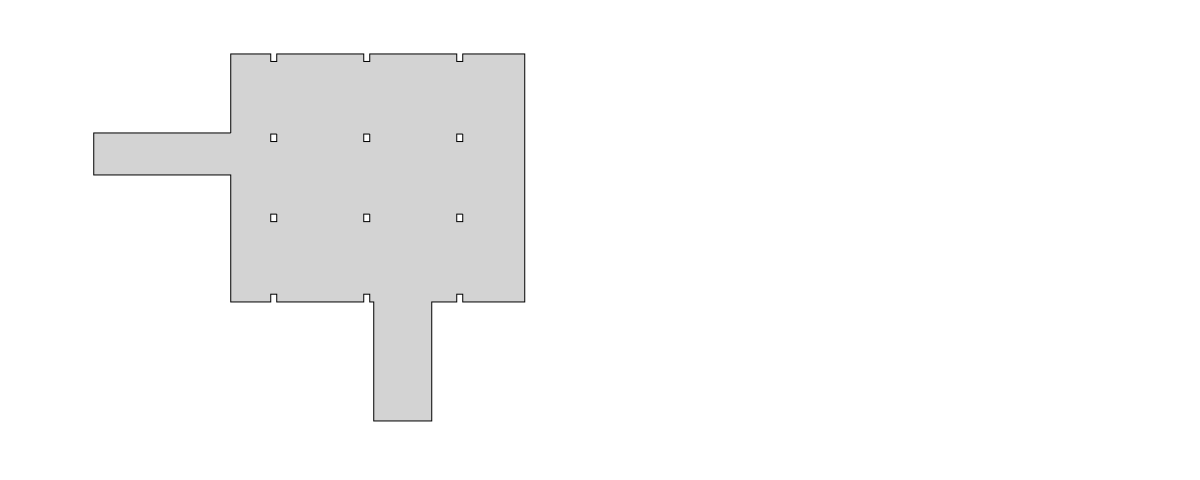

In [95]:
"""
Extinguisher.ipynb
TODO:
- Get floor definition from Revit
- Add Obstacles
- Add Doors (extinguisher to be closest to access points)
"""
__author__ = "Bob YX Lee"
import sys 
import os
import json
import drawsvg as dw
import random
from copy import deepcopy

sys.path.append("./packages")

from geom.Line2D import Line2D

MM = 100

data = {}
# Get random data point
datafiles = os.listdir("./dataset")
data_path = os.path.join("./dataset", random.choice(datafiles))
data = {}
with open(data_path, "r") as f:
    data = json.loads(f.read())

d = dw.Drawing(1200, 480, origin = (-MM*4, -MM*2), id_prefix='pic')
dpath = dw.Path(stroke = 'black', fill = 'lightgray')
#print(data)
surface = data["surface"]
floor_lines = []
surface["room"].append(surface["room"][0])

for i, p in enumerate(surface["room"]):
    
    if i == 0: 
        dpath.M(p[0]/MM, -p[1]/MM)
        p1 = (surface["room"][0])
        p2 = (surface["room"][1])
        floor_lines.append(Line2D(p1, p2))
        continue
    dpath.L(p[0]/MM, -p[1]/MM)
    if len(surface["room"]) - 1 == i: break
    p1 = (surface["room"][i])
    p2 = (surface["room"][i+1])
    floor_lines.append(Line2D(p1, p2))
    pass

obstacle_lines = []
for i,b in enumerate(surface["obstacles"]):
    b.append(b[0])
    for n,p in enumerate(b):
        if n == 0: 
            dpath.M(p[0]/MM, -p[1]/MM); 
            p1 = (surface["obstacles"][i][0])
            p2 = (surface["obstacles"][i][1])
            obstacle_lines.append(Line2D(p1, p2))    
            continue
        dpath.L(p[0]/MM, -p[1]/MM)
        if len(surface["obstacles"][i]) - 1 == n: break
        obstacle_lines.append(Line2D(surface["obstacles"][i][n], surface["obstacles"][i][n+1]))
    pass

d.append(dpath)

""" #DO NOT REMOVE
# FOR REFERENCE
floor = [
    [[0,0], [4 * MM, 0]]
    ,[[4*MM, 0], [8*MM, 0]]
    ,[[8*MM, 0], [8*MM, 5*MM]]
    ,[[8*MM, 5*MM], [5*MM, 5*MM]]
    ,[[5*MM, 5*MM], [5*MM, 19*MM]]
    ,[[5*MM, 19*MM], [8*MM, 19*MM]]
    ,[[8*MM, 19*MM], [8*MM, 23*MM]]
    ,[[8*MM, 23*MM], [0, 23*MM]]
    ,[[0, 23*MM], [0, 0]]
]

floor_lines = []

d = dw.Drawing(800, 600, origin = (-50, -50), id_prefix='pic')
for l in floor:
    line = dw.Line(l[0][0], l[0][1], l[1][0], l[1][1], stroke='black')
    floor_lines.append(Line2D(l[0], l[1]))
    d.append(line)
    pass
d
"""
#print(d.as_svg())
#print(floor_lines)
d

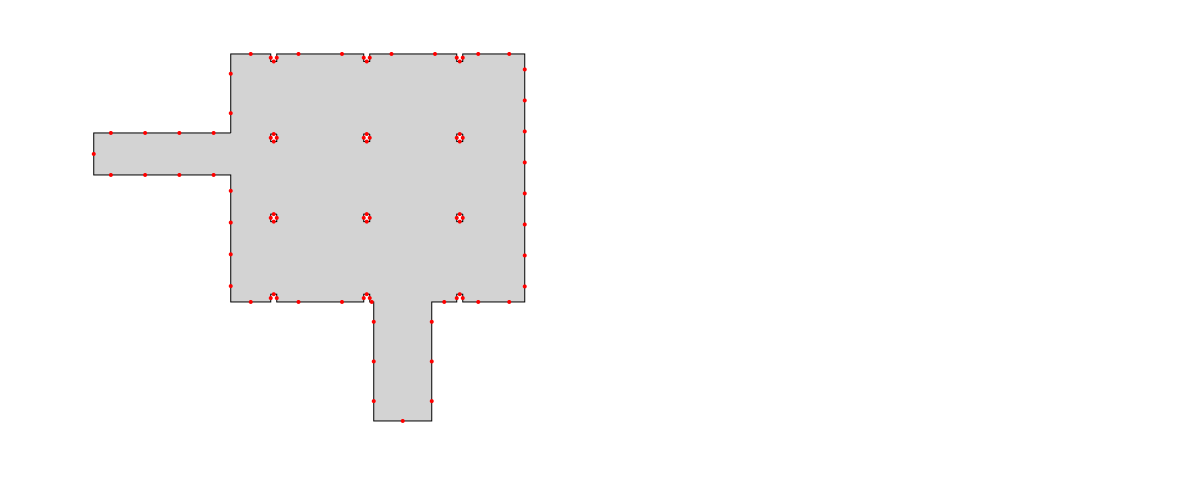

In [96]:
# Split into midpoints
# FIXME: Find out why 2 walls are missing...
floor_mids = []
div_len = 3000
for l in floor_lines:
    #print(l)
    if l.length < div_len:
        floor_mids.append(l.mid)
        #print("yee")
        continue
    divs = l.divideByLength(div_len)
    #print(len(divs))
    floor_mids.extend([s.mid for s in divs])

obstacle_mids = []
for l in obstacle_lines:
    #print(l.length)
    if l.length < div_len:
        obstacle_mids.append(l.mid)
        pass
    pass

#print(obstacle_mids[0])
#print(floor_mids)

d2 = deepcopy(d)

# Show possible extinguisher placements
for m in obstacle_mids:
    d2.append(dw.Circle(m[0]/MM, -m[1]/MM, 2, fill='red'))
for m in floor_mids:
    d2.append(dw.Circle(m[0]/MM, -m[1]/MM, 2, fill='red'))
d2

[-18638.37484993   6703.8560343 ]


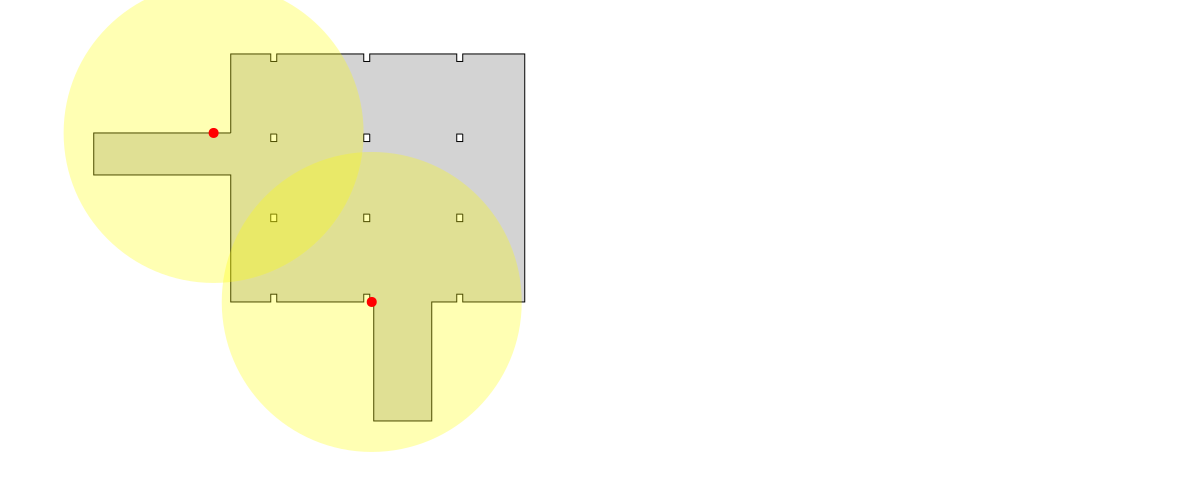

In [97]:
"""
PASS 1
TODO:
- Create iteration algorithm
"""
# Iterate through all possible combinations until boolean difference is 0
d3 = deepcopy(d)

def drawCoverage(d, pt):
    d.append(dw.Circle(pt[0]/MM, -pt[1]/MM, 15000/MM, fill='yellow', fill_opacity=0.3))
    d.append(dw.Circle(pt[0]/MM, -pt[1]/MM, 5, fill='red'))
    pass

tp = floor_mids[0]
# FIXME: Algorithm is not 100%... issue at [20]
tp1 = floor_mids[22]
print(tp)
drawCoverage(d3, tp)
drawCoverage(d3, tp1)

d3

[-18638.37484992743, 6703.856034298565]
{'result': [[-2825.8748499274043, -10196.143965701442], [-3025.874755859375, -9421.1435546875], [-16925.875, 6703.85595703125], [-18638.37484992743, 6703.856034298565]]}


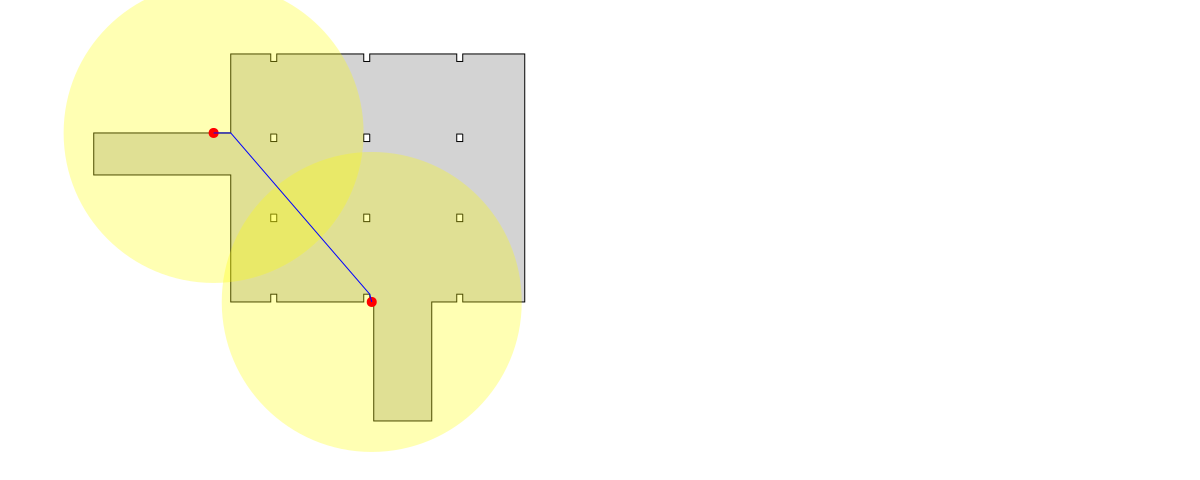

In [99]:
"""
PASS 2
- Make sure fire-route server is on!
- [x] Send navmesh
- [ ] Render shortest path
"""
import re
import requests

FIRE_ROUTE = "http://localhost:41982/travel"

start = [tp1[0], tp1[1]] #[-2625.874756, -22096.14453]
end = [tp[0], tp[1]] #[10258.994267, 4673.240059]
mesh = data["navmesh"]

payload = {"mesh": mesh, "start":start, "end": end}
print(end)
#print(payload)
res = requests.post(FIRE_ROUTE, json = payload)

travel = res.json()["result"]
print(res.json())

tpath = dw.Path(stroke = 'blue', fill = 'none')
for i, p in enumerate(travel):
    if(i == 0): tpath.M(p[0]/MM, -p[1]/MM); continue
    tpath.L(p[0]/MM, -p[1]/MM)
    pass

d4 = deepcopy(d3)
d4.append(tpath)

## BELOW IS DEPRECATED
## BUT DO NOT REMOVE. FOR REFERENCE.
#FIRE_ROUTE = "http://localhost:41414/mat"
#svg_xml = d.as_svg()
#paths = re.findall('(?<=d\=\")(.*)(?=\"\sstroke)', svg_xml)

#poly_path = []
#for i, p in enumerate(paths):
#    if i == 0:
#        pmod = p[0] + " " + p[1:]
#    if i > 0:
#        pmod = re.findall('\s(.*)', p)[0]
#    pmod = pmod.replace(",", " ")
#    poly_path.append(pmod)
    
#svg_str =" ".join(poly_path)
#res = requests.post(FIRE_ROUTE, json = {"svg": svg_str})
#print(res.json())

d4